In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model

In [2]:
Hitters = pd.read_csv('../Data/Hitters.csv', index_col=0)

In [3]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
Hitters.count() #counts non-NA values, notice Salary is 263

AtBat        322
Hits         322
HmRun        322
Runs         322
RBI          322
Walks        322
Years        322
CAtBat       322
CHits        322
CHmRun       322
CRuns        322
CRBI         322
CWalks       322
League       322
Division     322
PutOuts      322
Assists      322
Errors       322
Salary       263
NewLeague    322
dtype: int64

In [5]:
print(Hitters.isnull().sum()) #alternative to counting null values
Hitters = Hitters.dropna()
print(Hitters.count()) # now 263 for all

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64
AtBat        263
Hits         263
HmRun        263
Runs         263
RBI          263
Walks        263
Years        263
CAtBat       263
CHits        263
CHmRun       263
CRuns        263
CRBI         263
CWalks       263
League       263
Division     263
PutOuts      263
Assists      263
Errors       263
Salary       263
NewLeague    263
dtype: int64


In [6]:
# luckily the categorical variables are all binary, so i will just directly encode them
print(Hitters['League'].value_counts(),'\n', Hitters['NewLeague'].value_counts(),'\n', Hitters['Division'].value_counts())

A    139
N    124
Name: League, dtype: int64 
 A    141
N    122
Name: NewLeague, dtype: int64 
 W    134
E    129
Name: Division, dtype: int64


In [7]:
# Some of the columns have extra white-space
def binary_encoder(a,b):
    def _matcher(x):
        if x.strip()==a:
            return 1
        elif x.strip()==b:
            return 0
        else:
            raise ValueError('Value "{0}" not in [{}, {}]'.format(x,a,b))
    return _matcher
    
X = Hitters.drop('Salary', axis=1)
X['League'] = X['League'].map(binary_encoder('A','N')) 
X['NewLeague'] = X['NewLeague'].map(binary_encoder('A','N')) 
X['Division'] = X['Division'].map(binary_encoder('W','E'))
print(X['League'].value_counts(),'\n', X['NewLeague'].value_counts(),'\n', X['Division'].value_counts())

y = Hitters['Salary']

1    139
0    124
Name: League, dtype: int64 
 1    141
0    122
Name: NewLeague, dtype: int64 
 1    134
0    129
Name: Division, dtype: int64


In [105]:
# Note that these only work for data-sets whose categorical variables have already been encoded

from itertools import combinations
def all_subsets_search(X,y, fit_model, scorer):
    """Performs full subset search.
    WARNING: Does NOT implement the Leaps and Bounds algorithm. A full model will be fitted for each subset.
    Args:
        X (pandas.DataFrame): DataFrame of features to be selected
        y (pandas.Series): Series of target values
        model (sklearn model): form of model to fit.
        scorer (function): function(model,X,y) --> score for model
    Returns:
        Python Dictionary with following keys
        models (list): best model for each level of parameters
        scores (list): list of scores returned by scorer function for corresponding models
        Cp (list): list of Mallows Cp scores for corresponding models
        Params (dict): dictionary of arguments used to initiate search
    """
    
    results = {'models': [], 'scores': [], 'Cp': []}
    results['params'] = {'X': X,
                        'y': y,
                        'fit_model': fit_model,
                        'scorer': scorer}
    features = list(X.columns)
    n = len(y)
    full_model = fit_model(X.values,y.values)
    var_estimate = n*MSE(full_model, X.values, y.values)/(n-len(features)-1)

    for d in range(1, len(features)):
        scores = {}
        cp = {}
        for subset in combinations(features,d):
            cols = list(subset)
            model = fit_model(X[cols].values, y.values)
            scores[subset] = scorer(model,X[cols].values,y.values)
            cp[subset] = calc_cp(model,X[cols].values, y.values, var_estimate, n,len(subset))
        best_set = min(scores.keys(), key=scores.get)
        results['models'].append(best_set)
        results['scores'].append(scores[best_set])
        results['Cp'].append(cp[best_set])
    # add in full_model results
    results['models'].append(tuple(features))
    results['scores'].append(scorer(full_model,X.values,y.values))
    results['Cp'].append(calc_cp(full_model, X.values, y.values, var_estimate, n, len(features)))
    return results


def forward_subset_search(X, y, fit_model, scorer):
    """Performs forward selection search.
    Args:
        X (pandas.DataFrame): DataFrame of features to be selected
        y (pandas.Series): Series of target values
        model (sklearn model): form of model to fit.
        scorer (function): function(model,X,y) --> score for model
    Returns:
        Python Dictionary with following keys
        models (list): best model for each level of parameters
        scores (list): list of scores returned by scorer function for corresponding models
        Cp (list): list of Mallows Cp scores for corresponding models
        Params (dict): dictionary of arguments used to initiate search
    """
    
    results = {'models': [], 'scores': [], 'Cp': []}
    results['params'] = {'X': X,
                        'y': y,
                        'fit_model': fit_model,
                        'scorer': scorer}
    
    features = list(X.columns)
    n = len(y)
    full_model = fit_model(X.values,y.values)
    var_estimate = n*MSE(full_model, X.values, y.values)/(n-len(features)-1)
    
    features = []
    candidates = list(X.columns)
    #import pdb; pdb.set_trace()
    for d in range(len(candidates) - 1):
        scores = {}
        cp = {}
        for candidate in candidates:
            cols = features + [candidate]
            model = fit_model(X[cols].values, y.values)
            scores[candidate] = scorer(model, X[cols].values, y.values)
            cp[candidate] = calc_cp(model, X[cols].values, y.values, var_estimate, n, len(cols))
            
        best_feature= min(scores.keys(), key=scores.get)
        features.append(best_feature)
        candidates.remove(best_feature)
        
        results['models'].append(tuple(features))
        results['scores'].append(scores[best_feature])
        results['Cp'].append(cp[best_feature])
    
    results['models'].append(tuple(X.columns))
    results['scores'].append(scorer(full_model,X.values,y.values))
    results['Cp'].append(calc_cp(full_model, X.values, y.values, var_estimate, n, len(X.columns)))
    return results
    
def fit_linear_model(X,y):
    """Returns fitted sklearn LinearRegression model"""
    lr = linear_model.LinearRegression()
    return lr.fit(X,y)

def MSE(model,X, y):
    """Return mean squared error"""
    return ((y - model.predict(X))**2).mean()

def calc_cp(model, X, y, var_error, n, d):
    """Calculates Mallow's Cp for model"""
    RSS = ((y-model.predict(X))**2).sum()
    return RSS/var_error - n + 2*d

In [77]:
# warning this will take a while...
#regfit_full = all_subsets_search(X,y, fit_linear_model, MSE)
#regfit_full['params'] = {'X': X, 'y': y, 'fit_model': fit_linear_model, 'scorer': MSE}

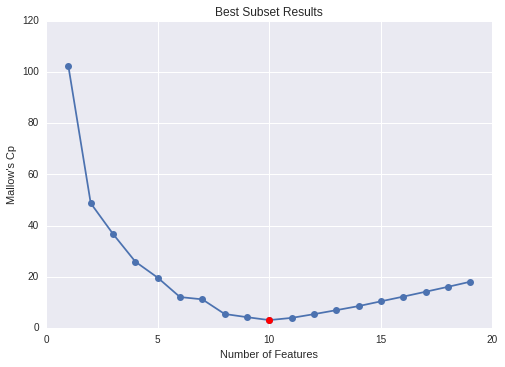

In [73]:
plt.plot(list(range(1,20)), alt_cps,  marker='o', linestyle='-')
plt.plot(np.argmin(regfit_full['Cp']) + 1, min(regfit_full['Cp']), 'ro') # python arrays are 0 indexed, hence the + 1
plt.xlabel('Number of Features')
plt.ylabel("Mallow's Cp")
plt.title("Best Subset Results")

In [75]:
# note, that other plot is nice, but I don't have time to reconstruct it right now

In [93]:
def get_coef(regfit, d):
    features = regfit['models'][d-1]
    fit_model, X, y = (regfit['params'][k] for k in ['fit_model', 'X', 'y'])
    model = fit_model(X[list(features)].values, y.values)
    coefs = model.coef_
    res = pd.Series({k:v for k,v in zip(features, coefs)})
    res['intercept'] = model.intercept_
    return res

In [97]:
get_coef(regfit_full, 10)

Assists        0.283168
AtBat         -2.168650
CAtBat        -0.130080
CRBI           0.774312
CRuns          1.408249
CWalks        -0.830826
Division    -112.380057
Hits           6.918017
PutOuts        0.297373
Walks          5.773225
intercept    162.535442
dtype: float64

In [106]:
regfit_fwd = forward_subset_search(X,y, fit_linear_model, MSE)

In [107]:
# you can verify this returns the same results
for model in regfit_fwd['models']: print(model)

('CRBI',)
('CRBI', 'Hits')
('CRBI', 'Hits', 'PutOuts')
('CRBI', 'Hits', 'PutOuts', 'Division')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs', 'Errors')
('CRBI', 'Hits', 'PutOuts', 'Division', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League', 'Runs', 'E

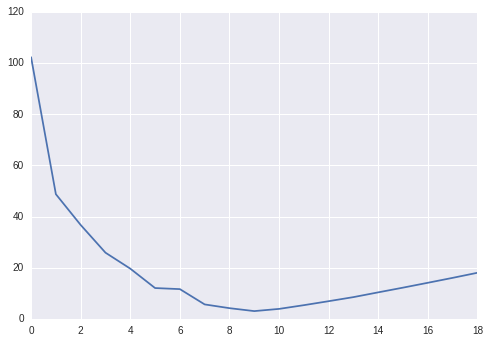

In [109]:
# Pretty similar Mallow's Cp plot
plt.plot(regfit_fwd['Cp'])

In [268]:
# it's interesting running this a few separate times, you get a **very** different results
# if you want to generat your own random samples, uncomment and run this cell

# np.random.seed(1)
# ix = list(range(len(y)))
# np.random.shuffle(ix)
# train, test = ix[:180], ix[180:]


In [323]:
# if you want to use the same samples as used in the lab, run this cell
with open('validation_sample.txt', 'r') as f:
    train = [int(i) - 1 for i in f.read().split()]
test = [i for i in range(len(y)) if i not in train]
all( i not in test for i in train)

True

In [324]:
# if you wanted to do it just like the R lab
def sparse_multiply(X_mat,b_vec):
    """Return sparse matrix-vector multiplication where betas not in b are assumed to be 0"""
    return sum(X_mat[j]*b_vec[j] for j in b_vec.index if j is not 'intercept') + b_vec['intercept']

regfit_fwd = forward_subset_search(X.iloc[train],y.iloc[train], fit_linear_model, MSE)

In [325]:
X_test, y_test = X.iloc[test], y.iloc[test]
cv_errors = []
for i in range(1,20):
    coefi = get_coef(regfit_fwd, i)
    pred = sparse_multiply(X_test, coefi)
    cv_errors.append( np.sqrt( ((pred-y_test)**2).mean() ))

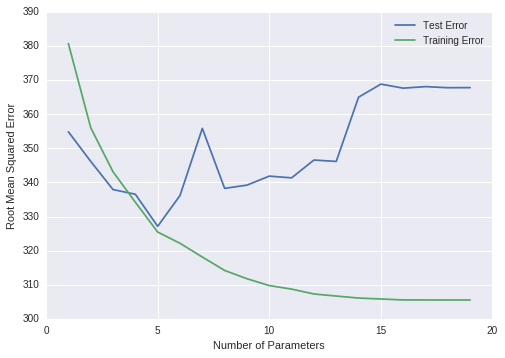

In [326]:
plt.plot(range(1,20), cv_errors, label='Test Error')
plt.plot(range(1,20), np.sqrt(regfit_fwd['scores']), label='Training Error')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Number of Parameters')
plt.legend()

In [327]:
# if you want to create your own random samples, uncoment and run this cell not the next one
# folds = np.random.randint(0,10, len(y))

# if you want the same folds as used in the lab
folds = [i%10 for i in range(263)]

In [329]:
print(len(folds))
counts = {}
for k in folds:
    counts[k] = counts.get(k,0) + 1
for k,v in counts.items(): print(k,v)

263
0 27
1 27
2 27
3 26
4 26
5 26
6 26
7 26
8 26
9 26


263


In [314]:
folds == folds2

True